## Week 3: Geospatial Data Analysis and GeoPandas

Sep 12, 2019

## Housekeeping

- Homework #2 due next week
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly
- Homework #1 has been graded
    - Graded files uploaded to your repositories
    - Please let me know of any issues/concerns

## Notes on assignment #1

- The notebooks should be "polished"
    - please remove any extra or unnecessary code
    - add markdown cells describing the various steps of your analysis
- Please put your name at the top of the assignment!

**Please send me your assignment #1 repository handle via email**

## Today's Agenda

- Vector data and introduction to GeoPandas
- Spatial relationships and joins
- Demo: 311 requests by neighborhood in Philadelphia
- Exercise: property assessments by neighborhood

## One note before we start...

## Getting all of the current variables

In [48]:
import pandas as pd
import numpy as np

In [49]:
x = np.ones(10)
x

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [50]:
y = x.sum()

In [51]:
%whos

Variable               Type                Data/Info
----------------------------------------------------
USA                    Series              iso_a3                   <...>nName: 168, dtype: object
ax                     AxesSubplot         AxesSubplot(0.165494,0.125;0.694013x0.755)
black                  module              <module 'black' from '/Us<...>/site-packages/black.py'>
ccrs                   module              <module 'cartopy.crs' fro<...>packages/cartopy/crs.py'>
cities                 GeoDataFrame                       name      <...>n\n[243 rows x 2 columns]
city_limits            GeoDataFrame           OBJECTID  Shape__Are  <...>01 40.1379348411103,...  
city_limits_mercator   GeoDataFrame           OBJECTID  Shape__Are  <...>6 4886006.88680784, ...  
countries              GeoDataFrame            iso_a3               <...>n\n[177 rows x 6 columns]
countries_mercator     GeoDataFrame            iso_a3               <...>n\n[176 rows x 6 columns]
crs             

## Now, on to geospatial analysis...

## Vector Data


- **vector** refers to **discrete geometric entities**
- The [Open Geospatial Consortium](https://en.wikipedia.org/wiki/Open_Geospatial_Consortium) has standardized a set of [**simple features**](https://en.wikipedia.org/wiki/Simple_Features)
- Includes points, lines, and polygons

<center>
    <img src=attachment:points-lines-polygons-vector-data-types.png width=600></img>
</center>

[Source](https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/)
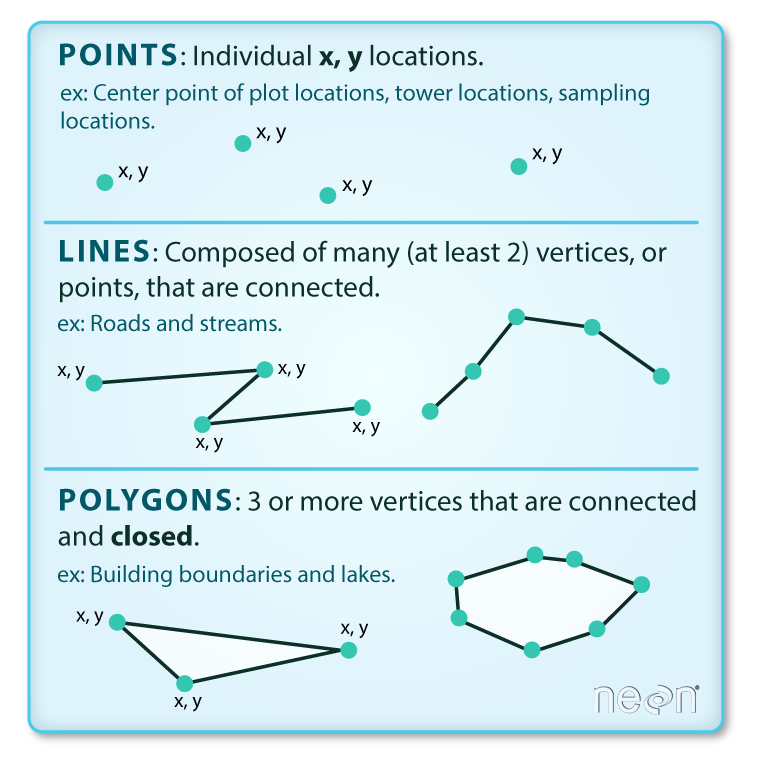

## A couple of terminology notes

- A **feature** refers to both the geometry and attributes of specific piece of vector data
- A **feature collection** is a list, or collection, of features

Both terms are very common in Python geospatial software.

## Common formats for vector datasets

## A shapefile

Actually several files with the same common prefix

Mandatory files: 

- **.shp**: the file containing the geometries
- **.shx**: the file that indexes the geometry
- **.dbf**: tabular data format storing the attributes for each geometry
    
And many optional files for documentation, projection information, etc.

Let's take a look at an example shapefile:

In [52]:
ls data/ne_110m_admin_0_countries/ 

ne_110m_admin_0_countries.cpg  ne_110m_admin_0_countries.shp
ne_110m_admin_0_countries.dbf  ne_110m_admin_0_countries.shx
ne_110m_admin_0_countries.prj


## The GeoJSON file

- Stores simple features in a JSON format
- Arose due to the prevalence of the JSON format, especially on the web

<center>
    <img src=attachment:Screen%20Shot%202019-02-04%20at%2011.09.38%20PM.png width=600></img>
</center>
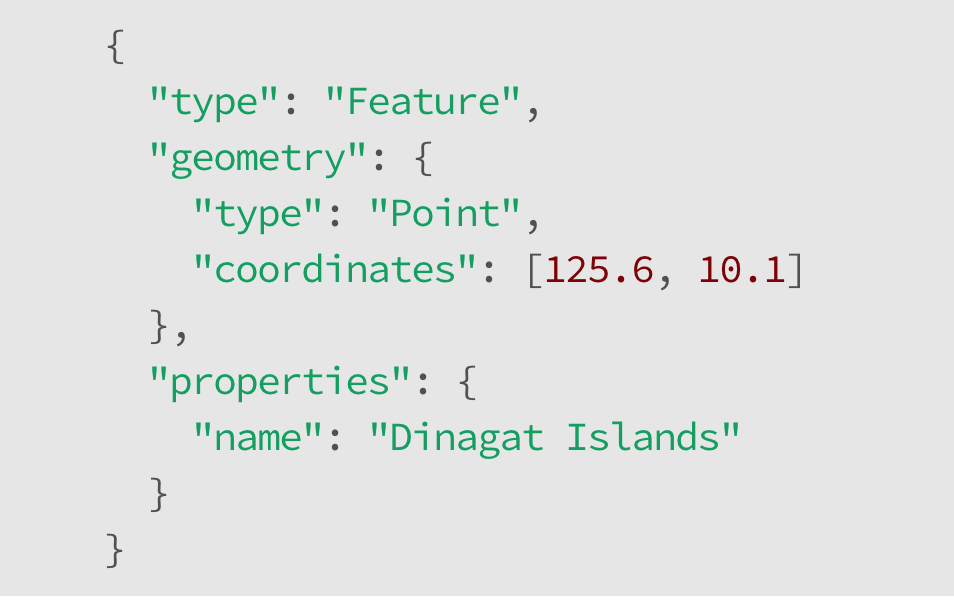

### Additional GeoJSON resources and tools:
- GitHub lets you view GeoJSON files natively 
- http://geojson.io provides interactive creation and viewing of small GeoJSON files

GitHub example from the `data/` directory: [Zipcodes.geojson](https://github.com/MUSA-620-Spring-2019/week-3/blob/master/data/Zipcodes_Poly.geojson)

## Reading Vector Data

`geopandas` provides a simple, intuitive for the main types of geospatial vector file formats

Let's load a shape file of countries in the world...

[Source: Natural Earth Data](http://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/)

In [53]:
import geopandas as gpd

We can use the `read_file()` function to read shapefiles and GeoJSON files.


There's also a `read_postgis` to read querys from PostGIS databases.

In [54]:
# read the shape file, giving the name of the directory
countries = gpd.read_file("./data/ne_110m_admin_0_countries")

In [55]:
countries.head()

iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry  
0  POLYGON ((61.21081709172574 35.65007233330923,...  
1  (POLYGON ((23.90415368011818 -11.7222815894063...  
2  POLYGON ((21.0200403174764 40.84272695572588, ...  
3  POLYGON ((51.57951867046327 24.24549713795111,...  
4  (POLYGON ((-66.95992000000001 -54.896810000000...

In [56]:
type(countries)

geopandas.geodataframe.GeoDataFrame

## What's a `GeoDataFrame`?

Just like a `DataFrame` but with a `geometry` column

In [57]:
countries.geometry.iloc[:10] 

0    POLYGON ((61.21081709172574 35.65007233330923,...
1    (POLYGON ((23.90415368011818 -11.7222815894063...
2    POLYGON ((21.0200403174764 40.84272695572588, ...
3    POLYGON ((51.57951867046327 24.24549713795111,...
4    (POLYGON ((-66.95992000000001 -54.896810000000...
5    POLYGON ((43.58274580259273 41.09214325618257,...
6    (POLYGON ((-59.57209469261159 -80.040178725096...
7    POLYGON ((68.935 -48.62500000000001, 69.58 -48...
8    (POLYGON ((145.3979781434949 -40.7925485166059...
9    POLYGON ((16.97966678230404 48.12349701597631,...
Name: geometry, dtype: object

## We can still leverage the power of `pandas`...

Calculate the total world population:

In [58]:
countries['pop_est'].sum()/1e9 

7.383089462

Calculate the total population on each continent:

In [59]:
grouped = countries.groupby('continent')
grouped 

<div class="alert alert-info" style="font-size:100%">
<b>REMEMBER</b>: <br>
    Remember: the <code>groupby()</code> does not return a <code>DataFrame</code> — you need to call <code>sum()</code>, <code>mean()</code>, etc, or <code>apply()</code> a function.
</div>

In [60]:
# sum population on each continent
pop_by_continent = grouped['pop_est'].sum()

# sort values
pop_by_continent.sort_values(ascending=False, inplace=True)

pop_by_continent

continent
Asia                       4.389145e+09
Africa                     1.219176e+09
Europe                     7.463985e+08
North America              5.730421e+08
South America              4.185407e+08
Oceania                    3.678284e+07
Antarctica                 4.050000e+03
Seven seas (open ocean)    1.400000e+02
Name: pop_est, dtype: float64

Filter the data frame based on a boolean selection:

In [61]:
is_USA = countries['name']=='United States of America'
USA = countries.loc[is_USA].squeeze()

USA

iso_a3                                                      USA
name                                   United States of America
continent                                         North America
pop_est                                             3.26626e+08
gdp_md_est                                            1.856e+07
geometry      (POLYGON ((-122.84 49.00000000000014, -120 49....
Name: 168, dtype: object

The simple features (Lines, Points, Polygons) are implemented by the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) library

In [62]:
type(USA.geometry)

shapely.geometry.multipolygon.MultiPolygon

Jupyter notebook renders `shapely` geometries automatically:

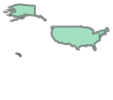

In [63]:
# a mini USA
USA.geometry 

## How does `geopandas` handle coordinate systems and map projections?



## Coordinate Reference Systems

A **coordinate reference system** (CRS) relates the position of a geometry object on the spherical earth to its two-dimensional coordinates.

A `GeoDataFrame` or `GeoSeries` has a `.crs` attribute which specifies the coordinate reference system.

In [64]:
countries.crs

{'init': 'epsg:4326'}

- EPSG 4326 is known as WGS84 where `x` and `y` are longitude and latitude. 
- It is is the default coordinate system for GPS systems.
- It's also known as Plate Carrée

## How to plot all of the geometries at once?

Use the `plot()` function to get a quick and dirty plot of all of the geometry features.

**Note:** the `plot()` returns the current maplotlib axes, allowing you to format the chart after plotting.

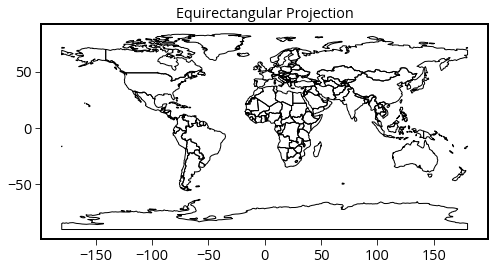

In [65]:
ax = countries.plot(facecolor='none', edgecolor='black')
ax.set_title('Equirectangular Projection');

<center>
    <img src=attachment:platecarree.png width=700></img>
</center>
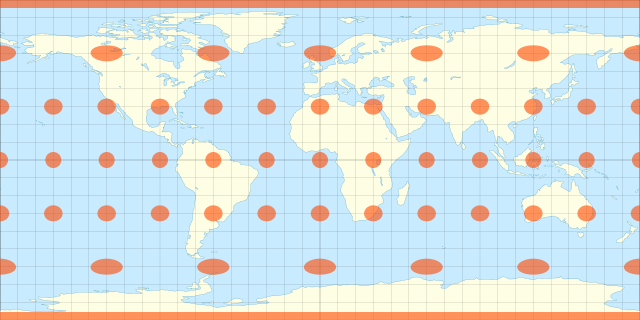

## What's going on under the hood?

`matplotlib` and `cartopy` are combined to make geo-aware plots

In [66]:
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

%matplotlib inline

In [67]:
plt.rcParams['figure.figsize'] = (8, 8)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>


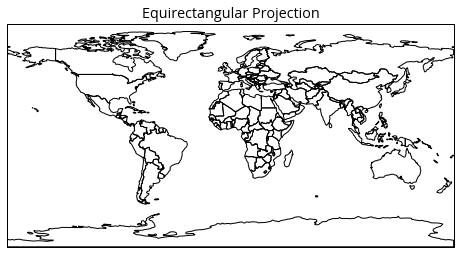

In [68]:
# initialize the CRS object
wgs84 = ccrs.PlateCarree()

# create a geo-aware axes
ax = plt.axes(projection=wgs84)

print(type(ax))
      
# add the geometry shapes
ax.add_geometries(countries['geometry'], crs=wgs84, facecolor='none', edgecolor='black')

# add a title
title = ax.set_title('Equirectangular Projection')

See the [geopandas documentation](https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html) for more examples.

## Can we convert to other geometries?

Use the `to_crs()` function. The most well-known projections can be specified by their EPSG code.

## Let's convert to the Mercator projection

[EPSG code: 3395](http://spatialreference.org/ref/epsg/wgs-84-world-mercator/)

In [69]:
# remove Antartica, as the Mercator projection cannot deal with the poles
no_antartica = countries[(countries['name'] != "Antarctica")]

In [70]:
countries_mercator = no_antartica.to_crs(epsg=3395)  # or .to_crs({'init': 'epsg:3395'})

In [71]:
countries_mercator.head() 

iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry  
0  POLYGON ((6813956.989691116 4227673.561898688,...  
1  (POLYGON ((2660998.215514913 -1305442.80953558...  
2  POLYGON ((2339940.184595554 4961221.198709426,...  
3  POLYGON ((5741805.753758118 2765811.384651245,...  
4  (POLYGON ((-7453944.197958336 -7306880.7041374...

## The easy way...

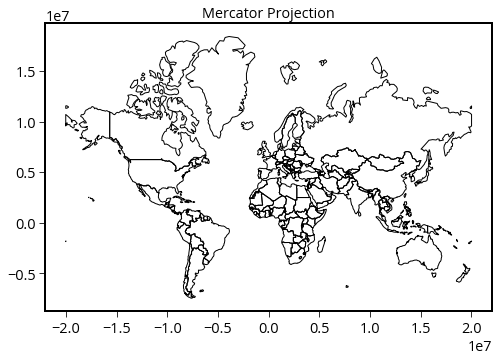

In [72]:
ax = countries_mercator.plot(facecolor='none', edgecolor='black')
title = ax.set_title('Mercator Projection')

## The harder way...

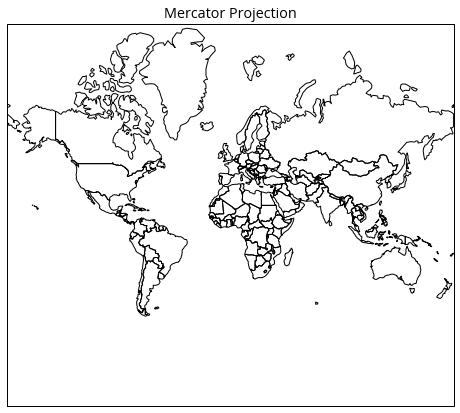

In [73]:
# initialize the CRS object
crs = ccrs.epsg(3395) # or crs = ccrs.Mercator()

# create a geo-aware axes
ax = plt.axes(projection=crs)

# add the geometry shapes
ax.add_geometries(countries_mercator['geometry'], crs=crs, facecolor='none', edgecolor='black')

# add a title
title = ax.set_title('Mercator Projection')

<center>
    <img src=attachment:mercator.png width=500></img>
</center>
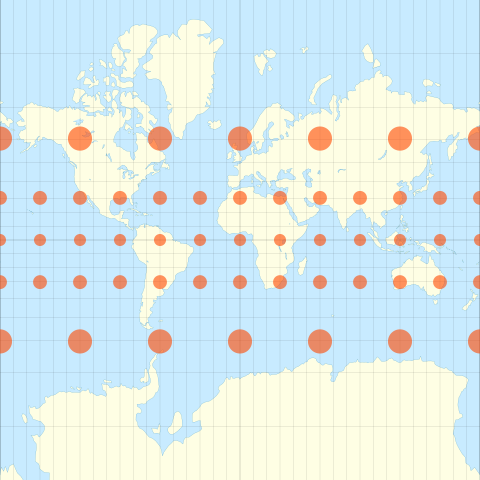

## When to use the 'harder' way?

When you need more customizable, advanced plots.

Nearly anything that `matplotlib` can do can be plotted on a `cartopy` `GeoAxes`. Plotting directly with `matplotlib` allows you to take full advantage of `matplotlib`'s functionality.

## So which CRS is best?

- For city-based data, usually Web Mercator ([EPSG=3857](https://epsg.io/3857)) is best
- Can also use a CRS specific to individual states, e.g., [PA State Plane EPSG=2272](https://epsg.io/2272)

## Let's load the city limits for Philadelphia

In [74]:
city_limits = gpd.read_file('./data/City_Limits')

city_limits

OBJECTID  Shape__Are  Shape__Len  \
0         1    0.038911    1.259687   

                                            geometry  
0  POLYGON ((-75.01496742025201 40.1379348411103,...

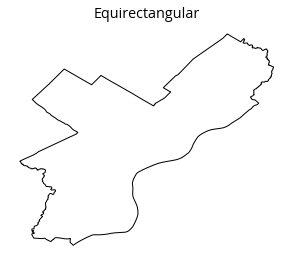

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))
city_limits.to_crs(epsg=4326).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_title("Equirectangular")
ax.set_axis_off()
ax.set_aspect("equal")

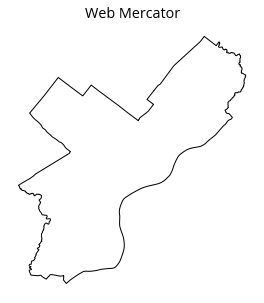

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
city_limits.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_title("Web Mercator")
ax.set_axis_off()
ax.set_aspect("equal")

**Important:** the equirectangular CRS (EPSG=4326) is often used by default and will make cities appear wider and flatter than they really are 

## Saving GeoDataFrames


Use the `to_file()` function and specify the driver.

In [77]:
city_limits_mercator = city_limits.to_crs(epsg=3857)

In [78]:
# ESRI shape file
city_limits_mercator.to_file("./data/city_limits_mercator", driver='ESRI Shapefile')

In [79]:
# GeoJSON is also an option
city_limits_mercator.to_file("./data/city_limits_mercator.geojson", driver='GeoJSON')

## How about as a CSV file?

Yes, but reading requires more work...

In [80]:
# save a csv file
city_limits_mercator.to_csv("./data/city_limits_mercator.csv", index=False)

In [81]:
import pandas as pd

In [82]:
df = pd.read_csv("./data/city_limits_mercator.csv")
df.head()

OBJECTID  Shape__Are  Shape__Len  \
0         1    0.038911    1.259687   

                                            geometry  
0  POLYGON ((-8350627.97509646 4886006.88680784, ...

In [83]:
type(df.geometry.iloc[0]) 

str

## Use `shapely` to parse the string version of the polygons

In [84]:
from shapely import wkt

# wkt.loads will convert from string to Polygon object
df['geometry'] = df['geometry'].apply(wkt.loads)

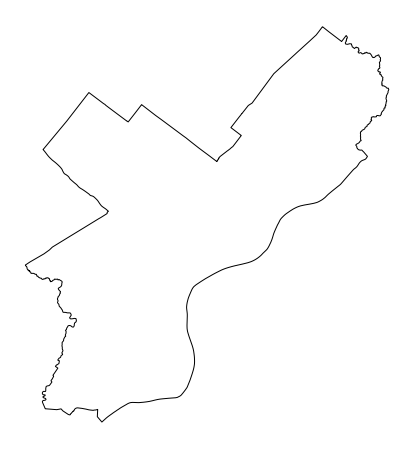

In [85]:
# make the GeoDataFrame, specifying the name of the geometry column
gdf = gpd.GeoDataFrame(df, geometry='geometry')
ax = gdf.plot(facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")

## So, when should you use GeoPandas?

- For exploratory data analysis and visualization, including in Jupyter notebooks
- Pre-processing data to be fed into a desktop GIS program
- For compact, readable, and reproducible code
- If you’re comfortable with Pandas and/or R data frames.

## When it may not be the best tool:

- For polished multilayer map creation — one option is to use a desktop GIS like QGIS.
- If you need very high performance — geopandas can be slow compared to other GIS software.

## Spatial Relationships and Joins

In [86]:
# load some cities data
cities = gpd.read_file("./data/ne_110m_populated_places")

<center>
    <img src=attachment:TopologicSpatialRelarions2.png width=600></img>
</center>

(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png))
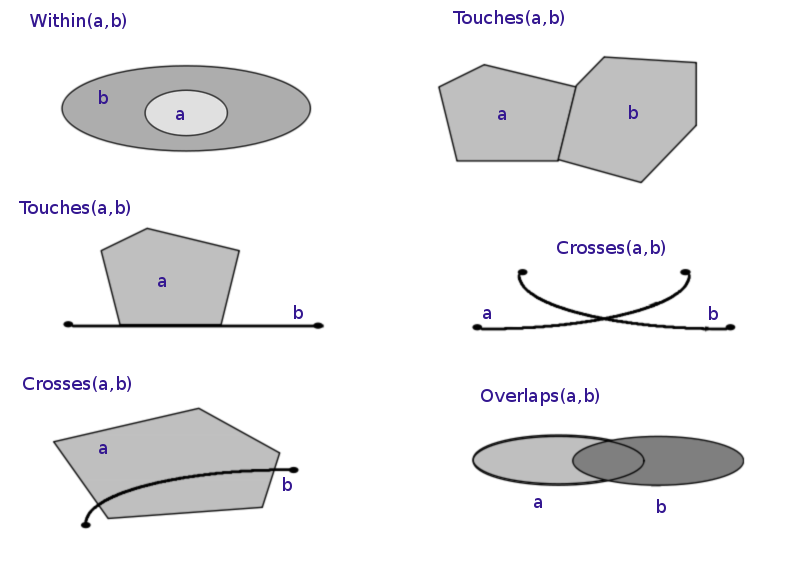

All of these operations are available as functions of a `GeoDataFrame`.

## A quick example

What country is New York in?

**spoiler**: the USA

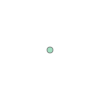

In [87]:
# select the Point representing New York City
new_york = cities.loc[cities['name'] == 'New York', 'geometry'].squeeze()
new_york

In [88]:
countries.contains(new_york)

0      False
1      False
2      False
3      False
4      False
       ...  
172    False
173    False
174    False
175    False
176    False
Length: 177, dtype: bool

In [89]:
# find the country that contains New York
countries.loc[countries.contains(new_york)]

iso_a3                      name      continent      pop_est  gdp_md_est  \
168    USA  United States of America  North America  326625791.0  18560000.0   

                                              geometry  
168  (POLYGON ((-122.84 49.00000000000014, -120 49....

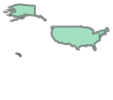

In [90]:
# save the USA polygon
USA = countries.loc[countries.contains(new_york), 'geometry'].squeeze()
USA

In [91]:
# is New York within the USA?
new_york.within(USA)

True

### Reference

The different functions for checking spatial relationships:

- `equals`
- `contains`
- `crosses`
- `disjoint`
- `intersects`

- `overlaps`
- `touches`
- `within`
- `covers`

See [the shapely documentation](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) for an overview of these methods.

## The spatial join


**SPATIAL JOIN** = merging attributes from two geometry layers based on their spatial relationship

Different parts of this operations:

- The GeoDataFrame to which we want add information
- The GeoDataFrame that contains the information we want to add
- The spatial relationship we want to use to match both datasets (**intersects**, **contains**, **within**)
- The type of join: **left** or **inner** join

In this case, we want to join the `cities` dataframe, containing `Point` geometries, with the information of the `countries` dataframe, containing `Polygon` geometries.

To match cities with countries, we'll use the `within` spatial relationship.

The [`geopandas.sjoin()`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) function performs this operation:

In [92]:
joined = gpd.sjoin(cities, countries, op='within', how='left')

In [93]:
joined.head()

name_left                                      geometry  index_right  \
0  Vatican City   POINT (12.45338654497177 41.90328217996012)         79.0   
1    San Marino     POINT (12.44177015780014 43.936095834768)         79.0   
2         Vaduz   POINT (9.516669472907267 47.13372377429357)          9.0   
3       Lobamba  POINT (31.19999710971274 -26.46666746135247)        152.0   
4    Luxembourg   POINT (6.130002806227083 49.61166037912108)         97.0   

  iso_a3  name_right continent     pop_est  gdp_md_est  
0    ITA       Italy    Europe  62137802.0   2221000.0  
1    ITA       Italy    Europe  62137802.0   2221000.0  
2    AUT     Austria    Europe   8754413.0    416600.0  
3    SWZ   Swaziland    Africa   1467152.0     11060.0  
4    LUX  Luxembourg    Europe    594130.0     58740.0

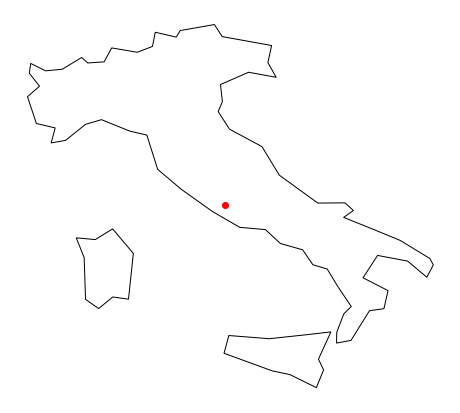

In [94]:
# find and plot italy
italy = countries.loc[countries['name']=='Italy']
ax = italy.plot(facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")

# plot the first city in the joined data frame (Vatican City)
# use the same axes!
ax = joined.iloc[:1].plot(ax=ax, color='red') 

## Spatial overlay operation

We can also perform the `join()` operation on the **geometries** rather than just combining **attributes**.

The `overlay()` function combines geometries, e.g. by taking the intersection of the geometries.

In [95]:
africa = countries[countries['continent'] == 'Africa'] 

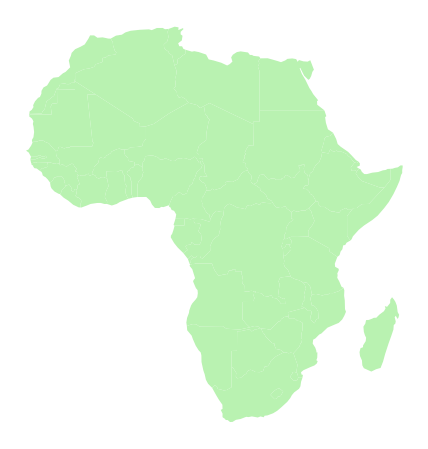

In [96]:
ax = africa.plot(facecolor='#b9f2b1')
ax.set_axis_off()
ax.set_aspect("equal") 

In [97]:
# add a buffer region (2 degrees) around all cities
buffered_cities = cities.copy()
buffered_cities['geometry'] = buffered_cities.buffer(2)

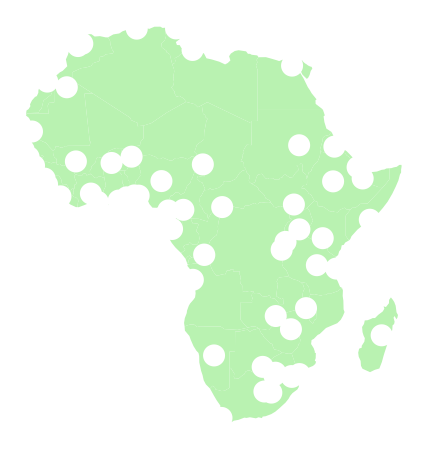

In [98]:
# the difference of the geometry sets
ax = gpd.overlay(africa, buffered_cities, how='difference').plot(facecolor="#b9f2b1")
ax.set_axis_off()
ax.set_aspect("equal")

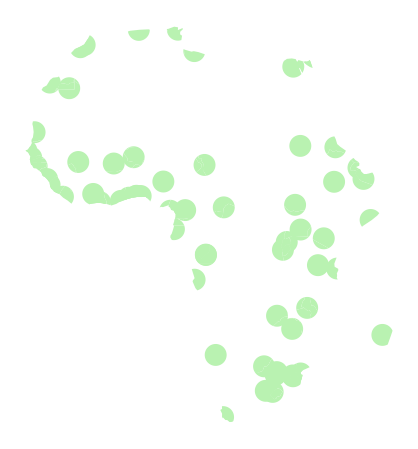

In [99]:
# the intersection of the geometry sets
ax = gpd.overlay(africa, buffered_cities, how='intersection').plot(facecolor="#b9f2b1")

ax.set_axis_off()
ax.set_aspect("equal")

### Recap:

- **Spatial join**: merge attributes from one data frame to another based on the spatial relationship
- **Spatial overlay**: creating new geometries based on spatial operation between both data frames (and combining attributes of both data frames)

## Putting it all together: 311 requests in 2018

Load 311 requests in Philadelphia from the `data/` directory.

Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

In [100]:
# load the data from a CSV file
requests = pd.read_csv('./data/public_cases_fc_2018.csv')

In [101]:
print("number of requests = ", len(requests))

number of requests =  609224


In [102]:
requests.head()

lat        lon  status                            service_name  \
0        NaN        NaN  Closed                     Information Request   
1        NaN        NaN  Closed                     Information Request   
2  39.952620 -75.177824  Closed                         Illegal Dumping   
3        NaN        NaN  Closed                     Information Request   
4  39.941155 -75.181570  Closed  Rubbish/Recyclable Material Collection   

                agency_responsible   requested_datetime     updated_datetime  \
0  Managing Director's Office- MDO  2018-02-12 17:01:36  2018-02-12 17:01:46   
1         Philly311 Contact Center  2018-02-09 18:34:34  2018-02-09 18:34:48   
2               Streets Department  2018-04-04 11:43:19  2018-04-10 06:31:12   
3            Department of Records  2018-02-13 12:02:13  2018-02-13 12:02:26   
4               Streets Department  2018-04-02 17:14:38  2018-04-10 06:31:13   

     expected_datetime  
0  2018-02-12 17:30:13  
1  2018-02-09 19:00:39  
2  2018-04-10 20:00:00  
3  2018-02-13 12:30:15  
4  2018-04-04 20:00:00

## First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [103]:
requests = requests.dropna(subset=['lat', 'lon'])

Create a list of (x,y) tuples and convert to Point objects:

In [104]:
requests['Coordinates'] = list(zip(requests['lon'], requests['lat']))

In [157]:
requests['Coordinates'].head()

2         POINT (-75.177824208 39.952619772)
4         POINT (-75.181569826 39.941155174)
5          POINT (-75.173004694 39.95455427)
6    POINT (-75.04253837600001 40.032329879)
7         POINT (-75.168836802 40.051672907)
Name: Coordinates, dtype: object

In [106]:
from shapely.geometry import Point
requests['Coordinates'] = requests['Coordinates'].apply(Point)

In [156]:
requests['Coordinates'].head()

2         POINT (-75.177824208 39.952619772)
4         POINT (-75.181569826 39.941155174)
5          POINT (-75.173004694 39.95455427)
6    POINT (-75.04253837600001 40.032329879)
7         POINT (-75.168836802 40.051672907)
Name: Coordinates, dtype: object

Now, convert to a GeoDataFrame.

**Important**
- Don't forget to set the CRS manually! 
- The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a dictionary: `{'init': 'epsg:4326'}`



In [108]:
requests = gpd.GeoDataFrame(requests, geometry="Coordinates", crs={"init": "epsg:4326"})

## Next, identify the top 20 most common requests

Group by the service name and calculate the size of each group:

In [109]:
service_types = requests.groupby('service_name').size()

Sort by the number (in descending order):

In [110]:
service_types = service_types.sort_values(ascending=False)

Slice the data to take the first 20 elements:

In [111]:
top20 = service_types.iloc[:20]
top20

service_name
Maintenance Residential or Commercial     28615
Rubbish/Recyclable Material Collection    25837
Street Defect                             25148
Illegal Dumping                           24653
Abandoned Vehicle                         20722
Graffiti Removal                          18136
Street Light Outage                       12465
Vacant Lot Clean-Up                        9269
LI Escalation                              7697
Vacant House or Commercial                 6932
Information Request                        6429
Sanitation / Dumpster Violation            5250
Street Trees                               4527
Building Force                             4513
Traffic Signal Emergency                   4457
Other (Streets)                            4123
Smoke Detector                             3552
Building Construction                      3266
Building Dangerous                         2589
Alley Light Outage                         2147
dtype: int64

## Let's trim to only the pothole requests

In [112]:
potholes = requests.loc[requests['service_name']=='Street Defect']
print('number of potholes = ', len(potholes))

number of potholes =  25148


## Let's convert from lat/lng to Web Mercator

The original data has EPSG=4326. We'll convert to EPSG=3857.

In [113]:
potholes = potholes.to_crs(epsg=3857)

In [155]:
potholes.head()

lat        lon  status   service_name  agency_responsible  \
57  39.945154 -75.151640  Closed  Street Defect  Streets Department   
58  39.946252 -75.146114  Closed  Street Defect  Streets Department   
59  39.946106 -75.155503  Closed  Street Defect  Streets Department   
67  39.964417 -75.240887  Closed  Street Defect  Streets Department   
70  39.972633 -75.144477  Closed  Street Defect  Streets Department   

     requested_datetime     updated_datetime    expected_datetime  \
57  2018-07-02 16:40:19  2018-07-23 15:03:18  2018-07-05 20:00:00   
58  2018-07-02 17:08:56  2018-07-23 15:03:20  2018-07-05 20:00:00   
59  2018-07-02 16:46:01  2018-07-23 15:03:21  2018-07-05 20:00:00   
67  2018-06-14 10:30:22  2018-06-27 12:01:09  2018-06-18 20:00:00   
70  2018-04-19 17:33:01  2018-04-20 10:31:11  2018-04-24 20:00:00   

                                     Coordinates  
57  POINT (-8365842.270585371 4857975.415923262)  
58  POINT (-8365227.122307514 4858134.893179198)  
59  POINT (-8366272.371249169 4858113.603676898)  
67  POINT (-8375777.225670485 4860772.792844045)  
70    POINT (-8365044.94361937 4861966.20525258)

## Calculate statistics by Zillow neighborhood

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

Source: https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [115]:
zillow = gpd.read_file('data/zillow_neighborhoods.geojson')
zillow = zillow.to_crs(epsg=3857)

In [116]:
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-8348795.676844054 4875297.327437357...
1           Airport  POLYGON ((-8370923.380392455 4850336.405079939...
2    Allegheny West  POLYGON ((-8367432.106275852 4866417.819736992...
3           Andorra  POLYGON ((-8373967.120433775 4875663.023801578...
4  Aston Woodbridge  POLYGON ((-8349918.769724508 4873746.906470324...

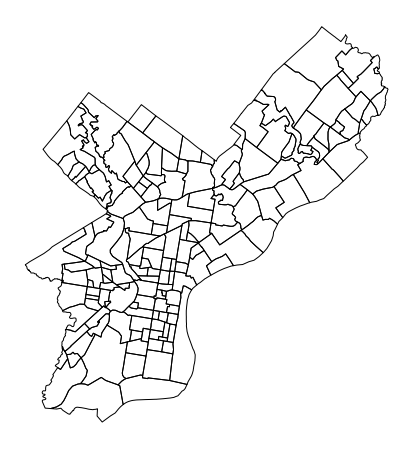

In [117]:
ax = zillow.plot(facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")

### Goal: for each neighborhood, calculate the number of potholes

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods)

In [118]:
joined = gpd.sjoin(potholes, zillow, op='within', how='left')

In [119]:
joined.head()

lat        lon  status   service_name  agency_responsible  \
57  39.945154 -75.151640  Closed  Street Defect  Streets Department   
58  39.946252 -75.146114  Closed  Street Defect  Streets Department   
59  39.946106 -75.155503  Closed  Street Defect  Streets Department   
67  39.964417 -75.240887  Closed  Street Defect  Streets Department   
70  39.972633 -75.144477  Closed  Street Defect  Streets Department   

     requested_datetime     updated_datetime    expected_datetime  \
57  2018-07-02 16:40:19  2018-07-23 15:03:18  2018-07-05 20:00:00   
58  2018-07-02 17:08:56  2018-07-23 15:03:20  2018-07-05 20:00:00   
59  2018-07-02 16:46:01  2018-07-23 15:03:21  2018-07-05 20:00:00   
67  2018-06-14 10:30:22  2018-06-27 12:01:09  2018-06-18 20:00:00   
70  2018-04-19 17:33:01  2018-04-20 10:31:11  2018-04-24 20:00:00   

                                     Coordinates  index_right  \
57  POINT (-8365842.270585371 4857975.415923262)        122.0   
58  POINT (-8365227.122307514 4858134.893179198)        122.0   
59  POINT (-8366272.371249169 4858113.603676898)        138.0   
67  POINT (-8375777.225670485 4860772.792844045)         60.0   
70    POINT (-8365044.94361937 4861966.20525258)         98.0   

           ZillowName  
57       Society Hill  
58       Society Hill  
59  Washington Square  
67         Haddington  
70     Old Kensington

Note that this operation can be **slow**

Group by neighborhood and calculate the size:

In [120]:
totals = joined.groupby('ZillowName').size()
type(totals)

pandas.core.series.Series

Convert to a data frame, and name the column.

**Also, reset the index so ZillowName is a column again**

In [121]:
totals = totals.to_frame('N').reset_index()
totals.head()

ZillowName    N
0   Academy Gardens   58
1           Airport   11
2    Allegheny West  123
3           Andorra    5
4  Aston Woodbridge   44

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of potholes per neighborhood (DataFrame).

**Important**
When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

For example...

In [122]:
totals = zillow.merge(totals, on='ZillowName')

In [123]:
totals.head()

ZillowName                                           geometry    N
0   Academy Gardens  POLYGON ((-8348795.676844054 4875297.327437357...   58
1           Airport  POLYGON ((-8370923.380392455 4850336.405079939...   11
2    Allegheny West  POLYGON ((-8367432.106275852 4866417.819736992...  123
3           Andorra  POLYGON ((-8373967.120433775 4875663.023801578...    5
4  Aston Woodbridge  POLYGON ((-8349918.769724508 4873746.906470324...   44

## Visualize as a choropleth map

Choropleth maps color polygon regions according to the values of a specific data attribute. *They are built-in to GeoDataFrame objects*.

First, plot the total number of requests per neighborhood.

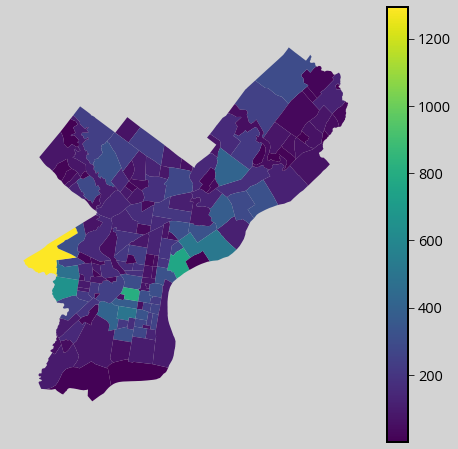

In [124]:
# Create the figure/axes
fig, ax = plt.subplots(facecolor="lightgray") # use a gray background

# Plot
totals.plot(ax=ax, column="N", edgecolor="none", legend=True, cmap="viridis")

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Can we make the aesthetics better?

## Yes!

- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [125]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

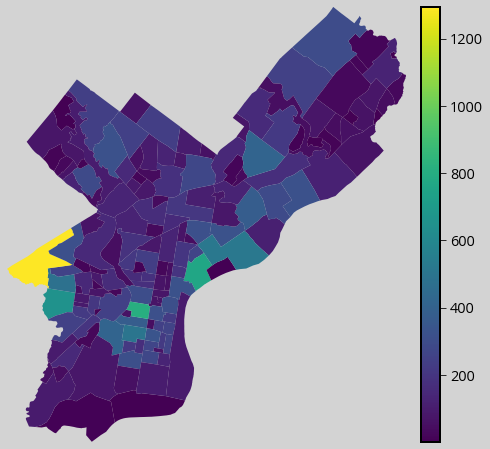

In [126]:
# Create the figure
fig, ax = plt.subplots(facecolor="lightgray")

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(ax=ax, cax=cax, column="N", edgecolor="none", legend=True, cmap="viridis")

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

These improvements are optional, but they definitely make for nicer plots!

## Can we classify the data into bins? 

Yes, built-in to the `plot()` function!

## Classification schemes

Many different schemes, but here are some of the most common ones:

1. "Quantiles" : assigns the same number of data points per bin
1. "EqualInterval" : divides the *range of the data* into equally sized bins
1. "FisherJenks": [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.
1. "UserDefined": allows you to specify your own bins

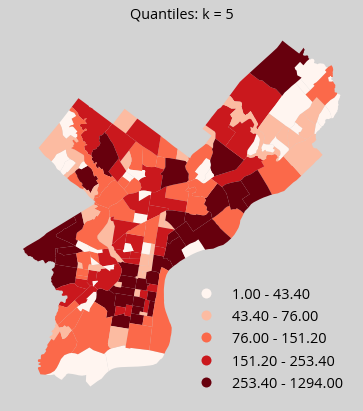

In [127]:
## Quantiles Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="Quantiles",
    k=5
)
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

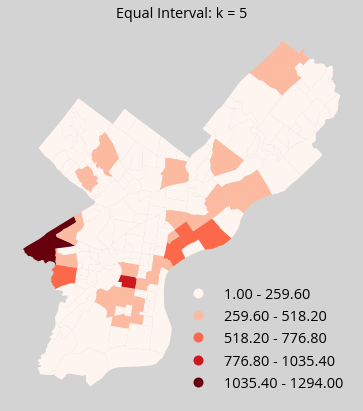

In [128]:
## Equal Interval Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="EqualInterval",
    k=5
)
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

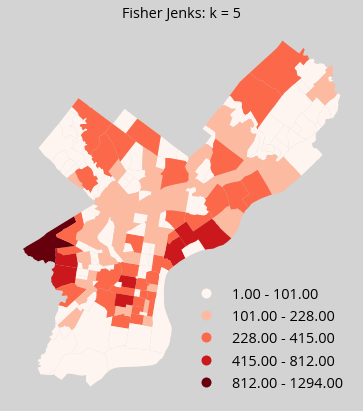

In [129]:
## Fisher Jenks Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="FisherJenks",
    k=5
)
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

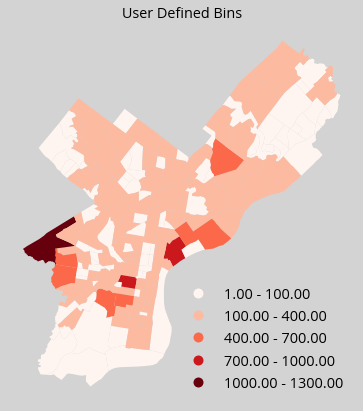

In [130]:
## User Defined Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="UserDefined", 
    classification_kwds=dict(bins=[100, 400, 700, 1000, 1300]) ## NEW: specify user defined bins
)
ax.set_title("User Defined Bins")
ax.set_axis_off()
ax.set_aspect("equal")

## Documentation for classification schemes

The documentation can be found here: https://pysal.org/mapclassify/api.html

Contains the full list of schemes and the function definitions for each.

## Neighborhood sizes still make it hard to compare raw counts

Better to normalize by area: **use the .area attribute of the geometry series**

In [131]:
totals['N_per_area'] = totals['N'] / (totals.geometry.area)

Now plot the normalized totals:

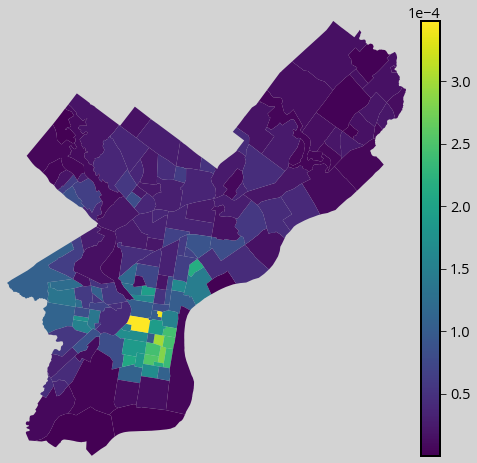

In [132]:
# Create the figure
fig, ax = plt.subplots(facecolor="lightgray")

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(ax=ax, cax=cax, column="N_per_area", edgecolor="none", legend=True, cmap="viridis")

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## More advanced: hex bins

Hexagonal bins aggregate quantities over small spatial regions.

**Use matplotlib's `hexbin()` function**

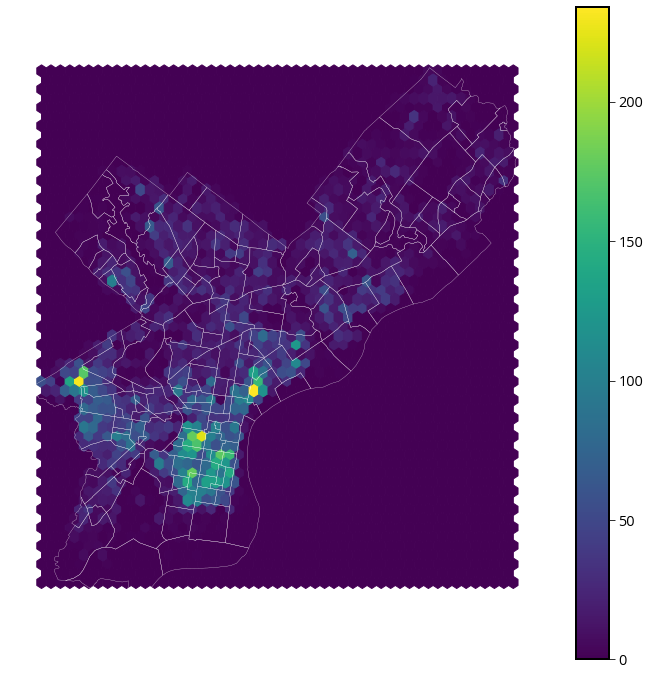

In [133]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# use the .x and .y attributes
vals = ax.hexbin(potholes.geometry.x, potholes.geometry.y, gridsize=50)

# add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)

# add a colorbar and format
plt.colorbar(vals)
ax.set_axis_off()
ax.set_aspect("equal")

## More advanced: adding a basemap

Let's plot a random sample of the potholes, with a nice basemap underneath.

We'll use the [contextily](https://github.com/darribas/contextily/) utility package.

In [134]:
import contextily as ctx

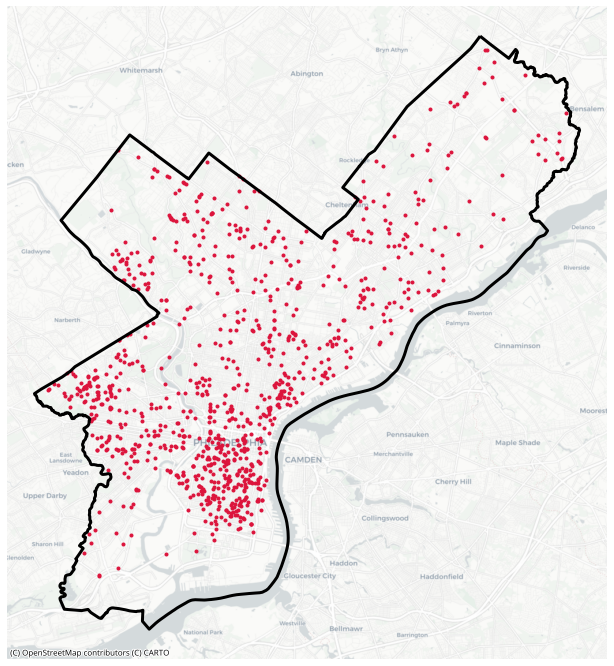

In [135]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot a random sample of potholes
potholes.sample(1000).plot(ax=ax, marker='.', color='crimson') # NEW: use the sample() function

# add the city limits
city_limits.to_crs(potholes.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=potholes.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

Lots of different tile providers available..

Easiest to use tab complete on `ctx.providers`

In [136]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'attribution': '(C) Openstreetmap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by 

### Let's try the "Dark Matter" theme...

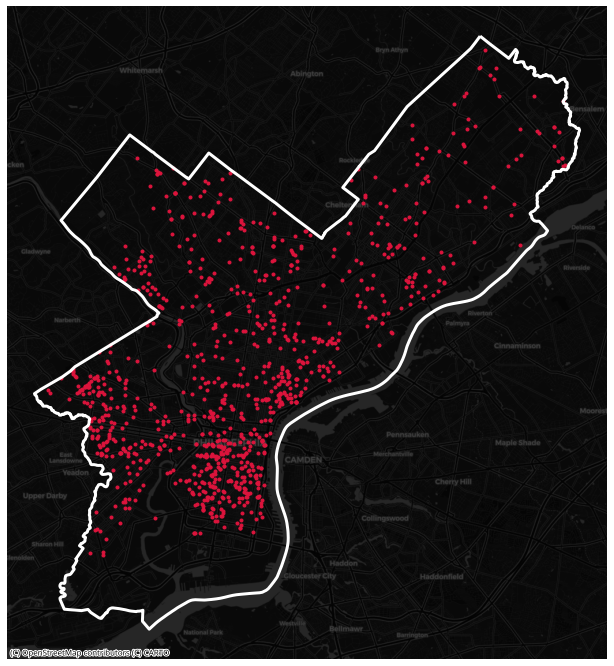

In [137]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot a random sample of potholes
potholes.sample(1000).plot(ax=ax, marker='.', color='crimson')

# add the city limits
city_limits.to_crs(potholes.crs).plot(ax=ax, edgecolor='white', linewidth=3, facecolor='none')

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=potholes.crs, url=ctx.providers.CartoDB.DarkMatter) # NEW: DarkMatter

# remove axis lines
ax.set_axis_off()

## Can we do better?

Yes! Let's add interactivity. We'll start with `altair`...

In [138]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

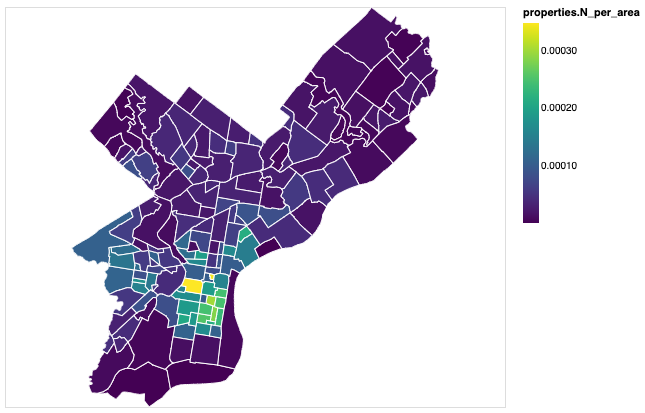

In [140]:
# create an altair data source from a GeoJSON representation
data = alt.InlineData(
    values=totals.to_crs(epsg=4326).to_json(),
    format=alt.DataFormat(property="features", type="json"),
)

# plot map, where variables ares nested within `properties`,
alt.Chart(data).mark_geoshape(stroke="white").properties(
    width=500, height=400, projection={"type": "mercator"}
).encode(
    tooltip=["properties.N_per_area:Q", "properties.ZillowName:N"],
    color=alt.Color("properties.N_per_area:Q", scale=alt.Scale(scheme='viridis'))
)

**Challenge for later:** use altair's *repeated charts* to show several choropleths for different 311 request types at once.

A similar example (using a different dataset) is available in the [altair gallery](https://altair-viz.github.io/gallery/choropleth_repeat.html).

## Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using a
1. static choropleth map
1. hex bin map
1. interactive choropleth with altair

**Challenge (if time remaining)**:
Visualize the highest-valued residential and commercial properties as points on top of a `contextily` basemap 

## Dataset

2019 property assessment data:
- from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- residential properties only — over 460,000 properties 

## Step 1: Load the assessment data

In [141]:
data = pd.read_csv('./data/opa_residential.csv')
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

We'll focus on the `market_value` column for this analysis

## Step 2: convert to a GeoDataFrame

In [142]:
data['Coordinates'] = list(zip(data['lng'], data['lat']))
data['Coordinates'] = data['Coordinates'].apply(Point)
data = gpd.GeoDataFrame(data, geometry='Coordinates', 
                            crs={'init': 'epsg:4326'})

In [143]:
len(data)

461460

## Step 3: do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

In [144]:
zillow.crs

{'init': 'epsg:3857', 'no_defs': True}

In [145]:
data = data.to_crs(epsg=3857)

In [146]:
gdata = gpd.sjoin(data, zillow, op='within', how='left')

/Users/nhand/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


## Step 4: make a choropleth of the median market value by neighborhood

Hints: 
- you will need to group by Zillow neighborhood
- calculate the median market value per neighborhood
- join with the Zillow neighborhood GeoDataFrame

In [160]:
grouped = gdata.groupby('ZillowName')
median_values = grouped['market_value'].median().reset_index()

In [161]:
median_values.head()

ZillowName  market_value
0   Academy Gardens      185950.0
1    Allegheny West       34750.0
2           Andorra      251900.0
3  Aston Woodbridge      183800.0
4   Bartram Village       48300.0

In [162]:
median_values = zillow.merge(median_values, on='ZillowName')
median_values['market_value'] /= 1e3 # in thousands

In [163]:
median_values.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-8348795.676844054 4875297.327437357...   
1    Allegheny West  POLYGON ((-8367432.106275852 4866417.819736992...   
2           Andorra  POLYGON ((-8373967.120433775 4875663.023801578...   
3  Aston Woodbridge  POLYGON ((-8349918.769724508 4873746.906470324...   
4   Bartram Village  POLYGON ((-8372041.314282436 4856283.291900341...   

   market_value  
0        185.95  
1         34.75  
2        251.90  
3        183.80  
4         48.30

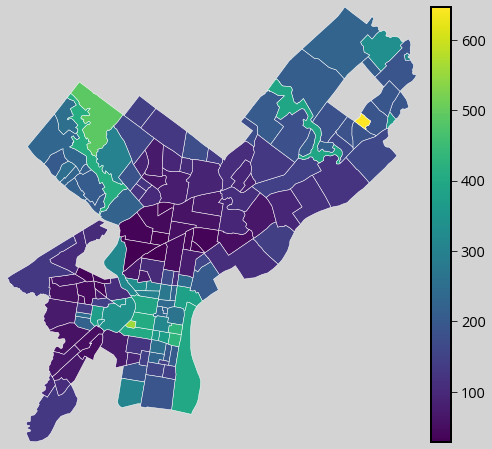

In [169]:
# Create the figure
fig, ax = plt.subplots(figsize=(8,8), facecolor="lightgray")

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
median_values.plot(ax=ax, cax=cax, column='market_value', edgecolor='white', linewidth=0.5, legend=True)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = median_values.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Step 5: make a hex bin map of median assessments

Hints: 
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

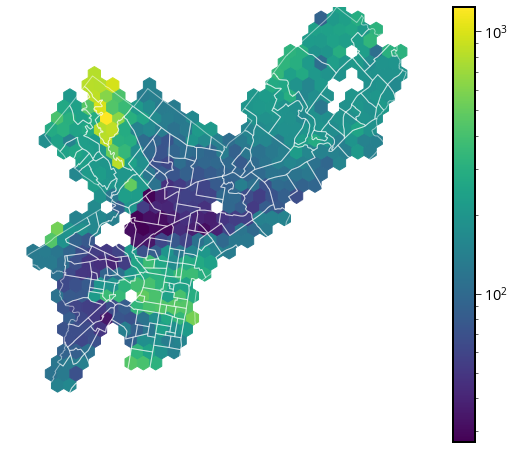

In [152]:
# create the axes
fig, ax = plt.subplots(figsize=(10, 8))

# use the .x and .y attributes
vals = ax.hexbin(
    gdata.geometry.x,
    gdata.geometry.y,
    C=gdata.market_value / 1e3,
    reduce_C_function=np.median,
    bins="log",
    gridsize=30,
)

# add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1, alpha=0.5)

# add a colorbar and format
plt.colorbar(vals)
ax.set_axis_off()
ax.set_aspect("equal")

## Step 6: Use altair to make an interactive choropleth

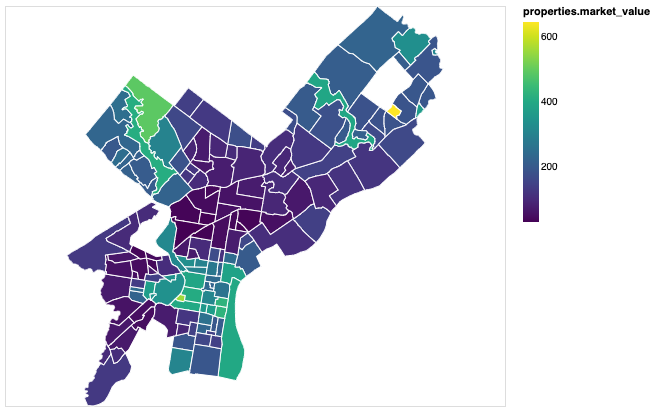

In [154]:
# create an altair data source from a GeoJSON representation
data = alt.InlineData(
    values=median_values.to_crs(epsg=4326).to_json(),
    format=alt.DataFormat(property="features", type="json"),
)

# plot map, where variables ares nested within `properties`,
alt.Chart(data).mark_geoshape(stroke="white").properties(
    width=500, height=400, projection={"type": "mercator"}
).encode(
    tooltip=["properties.market_value:Q", "properties.ZillowName:N"],
    color=alt.Color("properties.market_value:Q", scale=alt.Scale(scheme='viridis'))
)

## Properties with the highest assessed values

*They are all located in Center City*

In [171]:
sorted_properties = gdata.sort_values(by='market_value', ascending=False)
top20 = sorted_properties.iloc[:20]

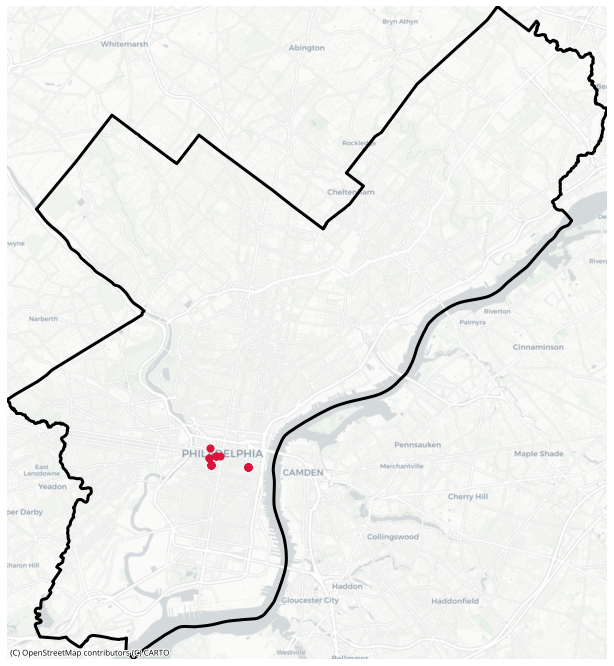

In [196]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot the top 20 properties by market value
top20.plot(ax=ax, marker='.', color='crimson', markersize=200) 

# add the city limits
city_limits = city_limits.to_crs(top20.crs)
city_limits.plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=top20.crs, url=ctx.providers.CartoDB.Positron)

# Set the xlims and ylims
xmin, ymin, xmax, ymax = city_limits.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# remove axis lines
ax.set_axis_off()